<h1><b>Regressão Logística</b><br>
<i>Conjunto de dados Diabetes Health Indicators</i></h1>

<b>Objetivo do modelo:</b><br>
Prever a probabilidade de um paciente ter diabetes.

<b>O conjunto de dados contém as seguintes variáveis:</b><br><i>
<b>gender:</b> Gênero da pessoa.<br>
<b>age:</b> Idade da pessoa.<br>
<b>hypertension:</b> Indica se a pessoa tem hipertensão.<br>
<b>heart_disease:</b> Indica se a pessoa tem alguma doença cardíaca conhecida.<br>
<b>smoking_history:</b> Histórico de tabagismo da pessoa.<br>
<b>bmi:</b> Índice de massa corporal.<br>
<b>HbA1c_level:</b> Nível de hemoglobina glicada — Média de glicose no sangue nos últimos meses<br>
<b>blood_glucose_level:</b> Glicose sanguínea.<br>
<b>diabetes:</b> Se a pessoa foi diagnosticada com diabetes ou não.<br></i>

### Importação das Bibliotecas

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Configurações de estilo para os gráficos

In [21]:
from plot_config import set_seaborn
set_seaborn()

### Importação e pré-visualização dos dados

In [22]:
df = pd.read_csv("diabetes.csv")
pd.options.display.float_format = '{:.2f}'.format

display(df.head())
registros = df.shape[0]
print(f"\n{registros} registros e {df.shape[1]} variáveis")

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0



100000 registros e 9 variáveis


### Quantidade de dados nulos

In [23]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

### Tipos de dados

In [24]:
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

### Dados inconsistentes e duplicados

In [25]:
for i in df.select_dtypes(include="object").columns:
  print(f"{i}: {df[i].unique()}")

gender: ['Female' 'Male' 'Other']
smoking_history: ['never' 'No Info' 'current' 'former' 'ever' 'not current']


### Transformação das Variáveis Categóricas

Codificação ordinal baseada em risco

In [26]:
smoking_map = {
    "never": 0,
    "not current": 1,
    "former": 2,
    "ever": 2,
    "current": 3,
    "No Info": -1
}

df["smoking_history_mapped"] = df["smoking_history"].map(smoking_map)
df.drop("smoking_history", axis=1, inplace=True)

One-hot encoding<br>
<small>"drop_first=True" para evitar multicolinearidade

In [27]:
df = pd.get_dummies(df, columns=["gender"], dtype=int, drop_first=True)

### Análise e tratamento de Outilies

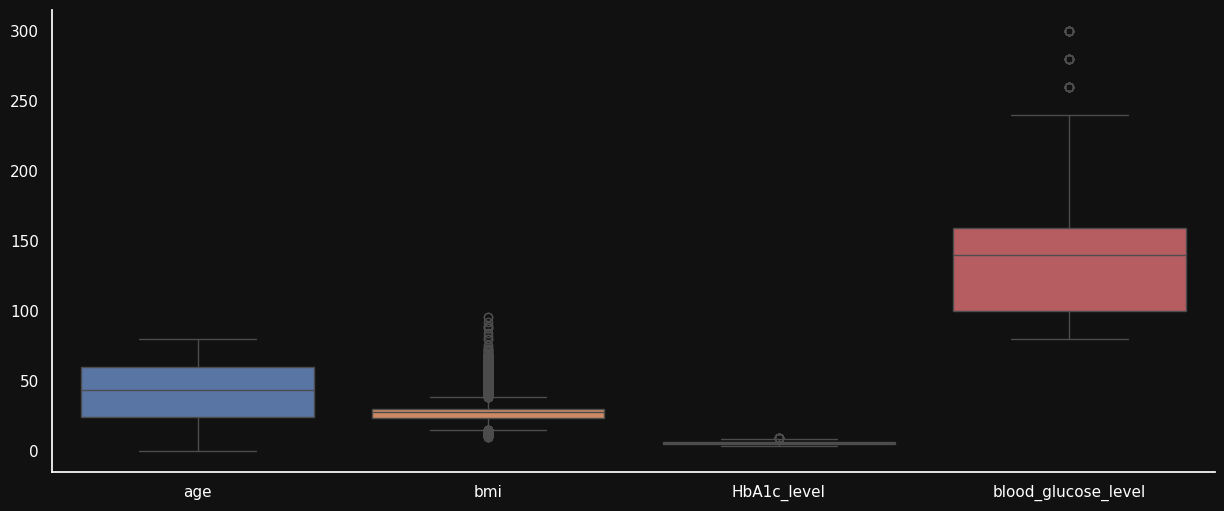

In [28]:
numericas = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]

sns.boxplot(df[numericas]);

Regra do 1,5 × Distância Interquartílica para identificação de Outlires

In [29]:
for i in df[numericas].columns:
  Q1 = df[i].quantile(0.25)
  Q3 = df[i].quantile(0.75)
  IQR = Q3 - Q1

  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR

  outliers_iqr = df[(df[i] < limite_inferior) | (df[i] > limite_superior)]

  print(f"Mínimo da variável '{i}' = {df[i].min()}\nMáximo da variável '{i}' = {df[i].max()}")
  print(f"Limites da variável '{i}' = {round(limite_inferior, 2)} a {round(limite_superior, 2)}")
  print(f"Outliers da variável '{i}' = {outliers_iqr[i].unique()}\n")

Mínimo da variável 'age' = 0.08
Máximo da variável 'age' = 80.0
Limites da variável 'age' = -30.0 a 114.0
Outliers da variável 'age' = []

Mínimo da variável 'bmi' = 10.01
Máximo da variável 'bmi' = 95.69
Limites da variável 'bmi' = 14.7 a 38.5
Outliers da variável 'bmi' = [54.7  13.99 56.43 ... 59.42 44.39 60.52]

Mínimo da variável 'HbA1c_level' = 3.5
Máximo da variável 'HbA1c_level' = 9.0
Limites da variável 'HbA1c_level' = 2.7 a 8.3
Outliers da variável 'HbA1c_level' = [9.  8.8]

Mínimo da variável 'blood_glucose_level' = 80
Máximo da variável 'blood_glucose_level' = 300
Limites da variável 'blood_glucose_level' = 11.5 a 247.5
Outliers da variável 'blood_glucose_level' = [260 300 280]



Valores que podem ser considerados outliers para cada variável aplicando o contexto clínico:<br>
age → valores muito baixos (crianças) ou muito altos (120 anos).<br>
bmi → valores < 10 ou > 70 geralmente são outliers.<br>
HbA1c_level → acima de 15 já é raro.<br>
blood_glucose_level → valores > 300–400 podem ser extremos.

In [30]:
df_without_outlier = df[(df["age"] > 17) & (df["bmi"].between(10, 70))]

print(f"Ao remover os outliers temos uma perda de {registros - df_without_outlier.shape[0]} registros")
print(f"Que representam {round(100 - ((df_without_outlier.shape[0] / registros) * 100), 2)}% dos dados")
print(f"Gerando uma amostra com {df_without_outlier.shape[0]} registros e {df_without_outlier.shape[1]} variáveis")

Ao remover os outliers temos uma perda de 17236 registros
Que representam 17.24% dos dados
Gerando uma amostra com 82764 registros e 10 variáveis


Na análise exploratória, foi detectado que 17,2% dos registros estavam fora dos limites de idade definidos (menores de 18 anos).
Como a exclusão dessa quantidade representa uma perda significativa de informação, será criado um dataframes diferente para testes alternativos.

In [31]:
df_outlier_age = df.copy()
df_outlier_age = df_outlier_age[df_outlier_age["bmi"].between(10, 70)]
df_outlier_age["outlier_age"] = np.where(df_outlier_age["age"] < 18, 1, 0)

print(f"Ao remover os outliers temos uma perda de {registros - df_outlier_age.shape[0]} registros")
print(f"Que representam {round(100 - ((df_outlier_age.shape[0] / registros) * 100), 2)}% dos dados")
print(f"Gerando uma amostra com {df_outlier_age.shape[0]} registros e {df_outlier_age.shape[1]} variáveis")

Ao remover os outliers temos uma perda de 19 registros
Que representam 0.02% dos dados
Gerando uma amostra com 99981 registros e 11 variáveis


### Modelo

In [32]:
X = df.drop(columns=["diabetes"])
y = df["diabetes"]

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000, penalty="l2", class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # probabilidade da classe positiva

### Avaliação do Modelo

<b>Precision:</b> Proporção dos acertos da categoria prevista.<br>
Entre os que o modelo disse que são positivos, quantos realmente são?<br>
<b>Recall:</b> Proporção dos acertos dentro da categoria real.<br>
Entre os que realmente são positivos, quantos o modelo conseguiu identificar?<br>
<b>F1-score:</b> Equilíbrio entre precision e recall (média harmônica).<br>
Útil quando as classes estão desbalanceadas.<br>
<b>AUC-ROC:</b> Mede a capacidade do modelo de separar positivos e negativos em todos os possíveis limiares de decisão.<br>
AUC próximo de 1 = ótimo separador, AUC ≈ 0.5 = aleatório.<br>

Classification Report (Precision, Recall, F1):
              precision    recall  f1-score   support

           0      0.989     0.888     0.935     18300
           1      0.424     0.889     0.574      1700

    accuracy                          0.888     20000
   macro avg      0.706     0.888     0.755     20000
weighted avg      0.941     0.888     0.905     20000

AUC-ROC: 0.963


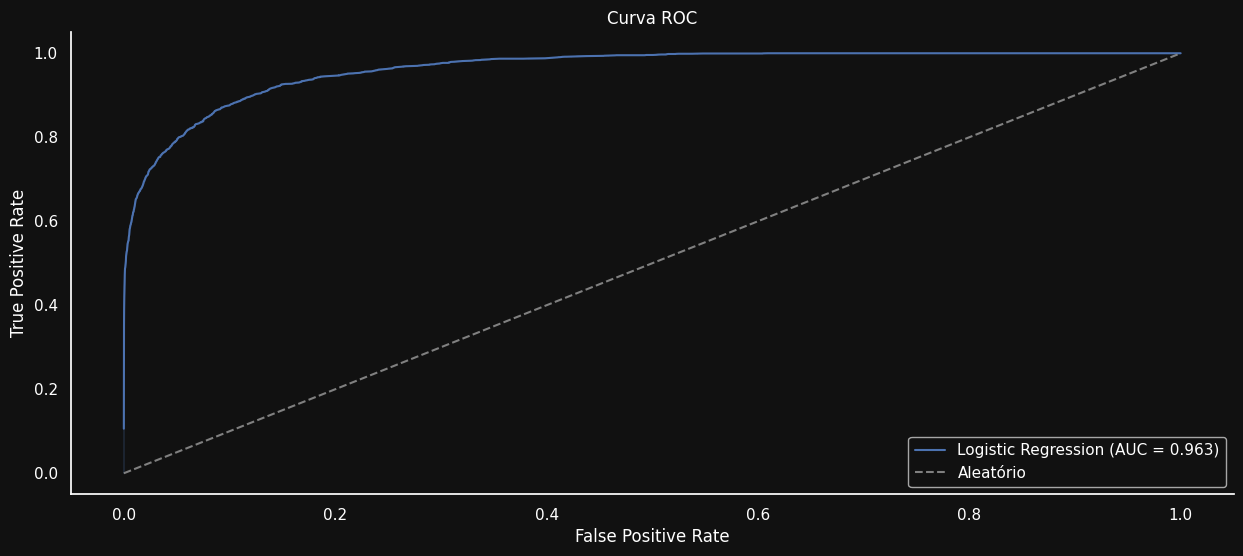

In [33]:
print("Classification Report (Precision, Recall, F1):")
print(classification_report(y_test, y_pred, digits=3))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC: {roc_auc:.3f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
sns.lineplot(x=fpr, y=tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})")
sns.lineplot(x=[0,1], y=[0,1], color="gray", linestyle="--", label="Aleatório")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.show()

### Seleção de Variáveis
Correlação de Pearson

In [34]:
display(df.corr(method="pearson"))

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_mapped,gender_Male,gender_Other
age,1.00,0.25,0.23,0.34,0.10,0.11,0.26,0.25,-0.03,-0.01
hypertension,0.25,1.00,0.12,0.15,0.08,0.08,0.20,0.10,0.01,-0.00
heart_disease,0.23,0.12,1.00,0.06,0.07,0.07,0.17,0.08,0.08,-0.00
bmi,0.34,0.15,0.06,1.00,0.08,0.09,0.21,0.19,-0.02,0.00
HbA1c_level,0.10,0.08,0.07,0.08,1.00,0.17,0.40,0.04,0.02,-0.00
blood_glucose_level,0.11,0.08,0.07,0.09,0.17,1.00,0.42,0.05,0.02,0.00
diabetes,0.26,0.20,0.17,0.21,0.40,0.42,1.00,0.11,0.04,-0.00
smoking_history_mapped,0.25,0.10,0.08,0.19,0.04,0.05,0.11,1.00,0.02,-0.00
gender_Male,-0.03,0.01,0.08,-0.02,0.02,0.02,0.04,0.02,1.00,-0.01
gender_Other,-0.01,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.01,1.00


Coeficientes Absolutos

In [35]:
coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coef": np.abs(model.coef_[0])
}).sort_values(by="Coef", ascending=False)

coeffs

,Feature,Coef
4,HbA1c_level,2.31
5,blood_glucose_level,1.29
0,age,1.10
3,bmi,0.65
1,hypertension,0.23
6,smoking_history_mapped,0.20
2,heart_disease,0.15
7,gender_Male,0.14
8,gender_Other,0.04


### Modelo

In [36]:
variaveis = ["HbA1c_level", "blood_glucose_level", "age", "bmi", "hypertension", "smoking_history_mapped"]

X = X[variaveis]
y = df["diabetes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000, penalty="l2", class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report (Precision, Recall, F1):")
print(classification_report(y_test, y_pred, digits=3))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC: {roc_auc:.3f}")

Classification Report (Precision, Recall, F1):
              precision    recall  f1-score   support

           0      0.989     0.884     0.934     18300
           1      0.417     0.890     0.568      1700

    accuracy                          0.885     20000
   macro avg      0.703     0.887     0.751     20000
weighted avg      0.940     0.885     0.902     20000

AUC-ROC: 0.962


### Explicabilidade do Modelo
Odds ratios ($exp(β)$)

In [37]:
coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coef": np.exp(model.coef_[0])
})
coeffs.sort_values(by="Coef", ascending=False)

,Feature,Coef
0,HbA1c_level,10.10
1,blood_glucose_level,3.65
2,age,3.17
3,bmi,1.90
4,hypertension,1.26
5,smoking_history_mapped,1.25
